In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples
k_max = 20000
t = np.linspace(0, k_max, k_max)  # Time variable

# Initialize u(k) and y(k) arrays with dtype float32
u = np.zeros(k_max, dtype=np.float32)
y = np.zeros(k_max, dtype=np.float32)

# Generate random inputs (float32)
u = (2 * np.random.uniform(-0.5, 0.5, k_max)).astype(np.float32)

# Define y(k) calculations with dtype float32
for k in range(1, k_max):
    y[k] = np.float32(1 / (1 + (y[k-1])**2)) + np.float32(0.25 * u[k]) - np.float32(0.3 * u[k-1])

# Shift arrays for y(k-1), y(k-2), u(k-1), u(k-2)
y_k_1 = np.zeros(k_max, dtype=np.float32)
y_k_2 = np.zeros(k_max, dtype=np.float32)
u_k_1 = np.zeros(k_max, dtype=np.float32)
u_k_2 = np.zeros(k_max, dtype=np.float32)

y_k_1[1:] = y[:-1]
y_k_2[2:] = y[:-2]
u_k_1[1:] = u[:-1]
u_k_2[2:] = u[:-2]

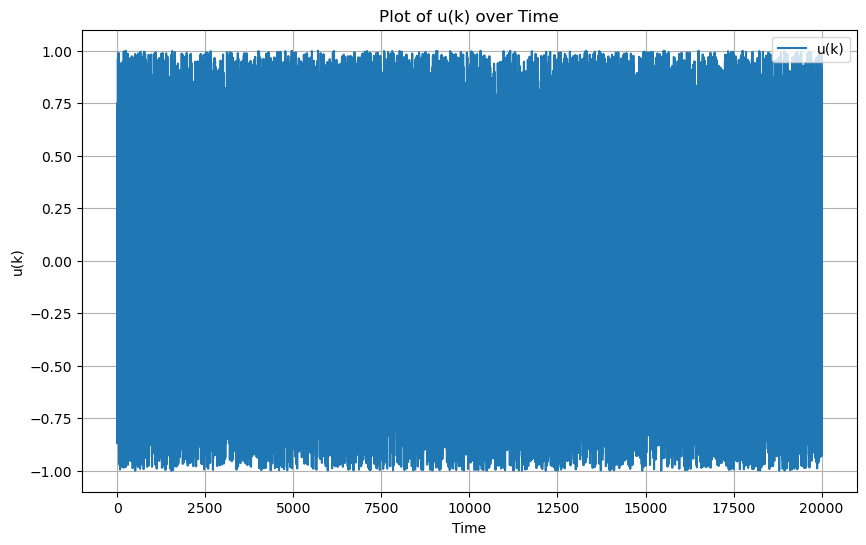

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(t, u, label='u(k)')
plt.xlabel('Time')
plt.ylabel('u(k)')
plt.title('Plot of u(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

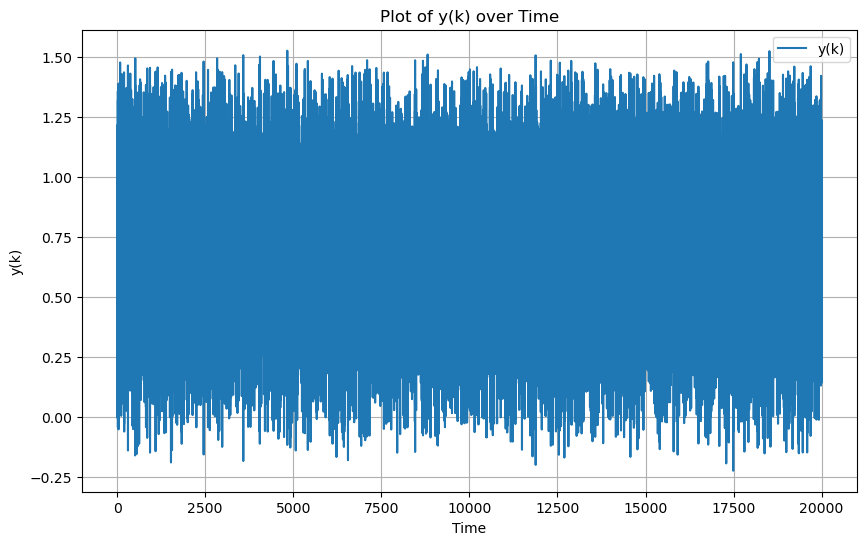

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='y(k)')
plt.xlabel('Time')
plt.ylabel('y(k)')
plt.title('Plot of y(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def normalize(data):
    data = data.astype(np.float32)
    return 2 * (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0)) - 1

def denormalize(normalized_data, data_min, data_max):
    normalized_data = normalized_data.astype(np.float32)
    return (normalized_data + 1) * (data_max - data_min) / 2 + data_min

In [6]:
# Split the data into training and validation sets
split_ratio = 0.5
split_index = int(k_max * split_ratio)

X = np.array([y_k_1, y_k_2, u, u_k_1, u_k_2]).T
y = y.reshape(-1, 1)

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Normalize inputs and outputs separately
u_norm = normalize(u)            # Normalize input u(k)
u_k_1_norm = normalize(u_k_1)    # Normalize u(k-1)
u_k_2_norm = normalize(u_k_2)    # Normalize u(k-2)

# Normalize and reshape y(k), y(k-1), and y(k-2)
y_norm = normalize(y).reshape(-1, 1)            # Normalize output y(k) and reshape to (k_max, 1)
y_k_1_norm = normalize(y_k_1).reshape(-1, 1)    # Normalize y(k-1) and reshape to (k_max, 1)
y_k_2_norm = normalize(y_k_2).reshape(-1, 1)    # Normalize y(k-2) and reshape to (k_max, 1)

# Combine normalized inputs into X (features matrix), no need to reshape X
X_norm = np.array([y_k_1_norm.flatten(), y_k_2_norm.flatten(), u_norm, u_k_1_norm, u_k_2_norm], dtype=np.float32).T

# Split the normalized data into training and validation sets
split_index = int(k_max * split_ratio)

X_train_norm = X_norm[:split_index]
X_val_norm = X_norm[split_index:]

y_train_norm = y_norm[:split_index]
y_val_norm = y_norm[split_index:]

In [7]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, l2_lambda=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda  # L2 regularization parameter

        # Initialize weights and biases using Nguyen-Widrow initialization
        self.W = []
        self.b = []

        # Layer 1 (input to first hidden layer)
        self.W.append(self.nguyen_widrow_init(input_size, hidden_sizes[0]))
        self.b.append(np.zeros((1, hidden_sizes[0]), dtype=np.float32))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.W.append(self.nguyen_widrow_init(hidden_sizes[i - 1], hidden_sizes[i]))
            self.b.append(np.zeros((1, hidden_sizes[i]), dtype=np.float32))

        # Output layer (last hidden layer to output)
        self.W.append(self.nguyen_widrow_init(hidden_sizes[-1], output_size))
        self.b.append(np.zeros((1, output_size), dtype=np.float32))

    def nguyen_widrow_init(self, input_size, output_size):
        """Nguyen-Widrow initialization."""
        W = np.random.randn(input_size, output_size).astype(np.float32) * 0.5
        beta = 0.7 * (output_size ** (1.0 / input_size))
        norm = np.linalg.norm(W, axis=0)
        return beta * W / norm

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def r2_score(self, y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) + 1e-4  # Prevent division by zero
        return 1 - (ss_res / ss_tot)

    def forward(self, X):
        # Forward pass through all layers
        self.activations = []  # Store activations for backpropagation
        self.Z = []  # Store pre-activation values

        # Input to first hidden layer
        Z = np.dot(X, self.W[0]) + self.b[0]
        A = self.tanh(Z)
        self.Z.append(Z)
        self.activations.append(A)

        # Hidden layers
        for i in range(1, len(self.hidden_sizes)):
            Z = np.dot(self.activations[-1], self.W[i]) + self.b[i]
            A = self.tanh(Z)
            self.Z.append(Z)
            self.activations.append(A)

        # Apply tanh at the output layer (for control system constraint)
        Z = np.dot(self.activations[-1], self.W[-1]) + self.b[-1]
        A = Z
        self.Z.append(Z)
        self.activations.append(A)

        return A  # Final output after tanh activation
    
    def predict(self, X_new):
        """
        Predict the output for new input data.
        :param X_new: New input data (numpy array)
        :return: Predicted output (numpy array)
        """
        # Use the forward pass to get the prediction
        prediction = self.forward(X_new)
        return prediction

    def backward(self, X, y_true, y_pred):
        m = X.shape[0]  # Number of training samples

        # Gradient for output layer
        dZ = (y_pred - y_true) # Derivative of MSE loss w.r.t. Z
        dW = np.dot(self.activations[-2].T, dZ) / m + (self.l2_lambda * self.W[-1] / m)  # L2 regularization
        db = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases for output layer
        self.W[-1] -= self.learning_rate * dW
        self.b[-1] -= self.learning_rate * db

        # Backpropagate through the hidden layers
        for i in range(len(self.hidden_sizes) - 1, 0, -1):
            dA = np.dot(dZ, self.W[i + 1].T)
            dZ = dA * self.tanh_derivative(self.Z[i])
            dW = np.dot(self.activations[i - 1].T, dZ) / m + (self.l2_lambda * self.W[i] / m)
            db = np.sum(dZ, axis=0, keepdims=True) / m

            self.W[i] -= self.learning_rate * dW
            self.b[i] -= self.learning_rate * db

        # Gradient for the first hidden layer
        dA = np.dot(dZ, self.W[1].T)
        dZ = dA * self.tanh_derivative(self.Z[0])
        dW = np.dot(X.T, dZ) / m + (self.l2_lambda * self.W[0] / m)
        db = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases for the first hidden layer
        self.W[0] -= self.learning_rate * dW
        self.b[0] -= self.learning_rate * db

    def train(self, X_train, y_train, X_val, y_val, epochs):
        # Create attributes for the losses and accuracies to be accessed later
        self.train_losses, self.val_losses = [], []
        self.train_r2_scores, self.val_r2_scores = [], []

        # Store predictions as attributes
        self.y_train_pred = None  # To store training predictions
        self.y_val_pred = None  # To store validation predictions

        print(f"{'Epoch':<10}{'Train Loss':<15}{'Train R²':<15}{'Val Loss':<15}{'Val R²':<15}")
        print("=" * 65)

        for epoch in range(epochs):
            # Forward pass (training set)
            self.y_train_pred = self.forward(X_train)  # Store training predictions

            # Compute training loss and R² score
            train_loss = self.mse_loss(y_train, self.y_train_pred)
            train_r2 = self.r2_score(y_train, self.y_train_pred)

            # Forward pass (validation set)
            self.y_val_pred = self.forward(X_val)  # Store validation predictions

            # Compute validation loss and R² score
            val_loss = self.mse_loss(y_val, self.y_val_pred)
            val_r2 = self.r2_score(y_val, self.y_val_pred)

            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_r2_scores.append(train_r2)
            self.val_r2_scores.append(val_r2)

            # Backward pass (training set)
            self.backward(X_train, y_train, self.y_train_pred)

            # Print progress every 100 epochs
            if (epoch + 1) % 100 == 0:
                print(f"{epoch + 1:<10}{train_loss:<15.4f}{train_r2:<15.4f}{val_loss:<15.4f}{val_r2:<15.4f}")

        print("=" * 65)
        print(f"Final Training Loss: {train_loss:.4f}, Final Training R²: {train_r2:.4f}")
        print(f"Final Validation Loss: {val_loss:.4f}, Final Validation R²: {val_r2:.4f}")

        # After training, plot the metrics
        self.plot_training_history(self.train_losses, self.val_losses, self.train_r2_scores, self.val_r2_scores)

    def plot_training_history(self, train_losses, val_losses, train_r2_scores, val_r2_scores):
        epochs_range = range(1, len(train_losses) + 1)

        plt.figure(figsize=(14, 6))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_losses, label="Training Loss")
        plt.plot(epochs_range, val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (MSE)")
        plt.title("Training and Validation Loss")
        plt.legend()

        # R² Scores plot (Accuracy)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_r2_scores, label="Training R² Score")
        plt.plot(epochs_range, val_r2_scores, label="Validation R² Score")
        plt.xlabel("Epochs")
        plt.ylabel("R² Score")
        plt.title("Training and Validation R² Score")
        plt.legend()

        plt.show()

In [8]:
# Initialize the neural network
input_size = 5
hidden_sizes = [7]  # hidden layers with 7 neurons each
output_size = 1
learning_rate = 0.03  # Reduced learning rate for stability
l2_lambda = 0.001  # Regularization parameter
epochs = 10000

nn = NeuralNetwork(input_size, hidden_sizes, output_size, learning_rate, l2_lambda)

Epoch     Train Loss     Train R²       Val Loss       Val R²         
100       0.1665         -0.1517        0.1633         -0.1441        
200       0.0838         0.4202         0.0820         0.4256         
300       0.0416         0.7121         0.0406         0.7156         
400       0.0214         0.8523         0.0207         0.8547         
500       0.0117         0.9191         0.0113         0.9209         
600       0.0070         0.9514         0.0067         0.9529         
700       0.0047         0.9674         0.0045         0.9687         
800       0.0035         0.9756         0.0033         0.9768         
900       0.0029         0.9799         0.0027         0.9810         
1000      0.0026         0.9822         0.0024         0.9834         
1100      0.0024         0.9836         0.0022         0.9847         
1200      0.0023         0.9844         0.0021         0.9855         
1300      0.0022         0.9849         0.0020         0.9860         
1400  

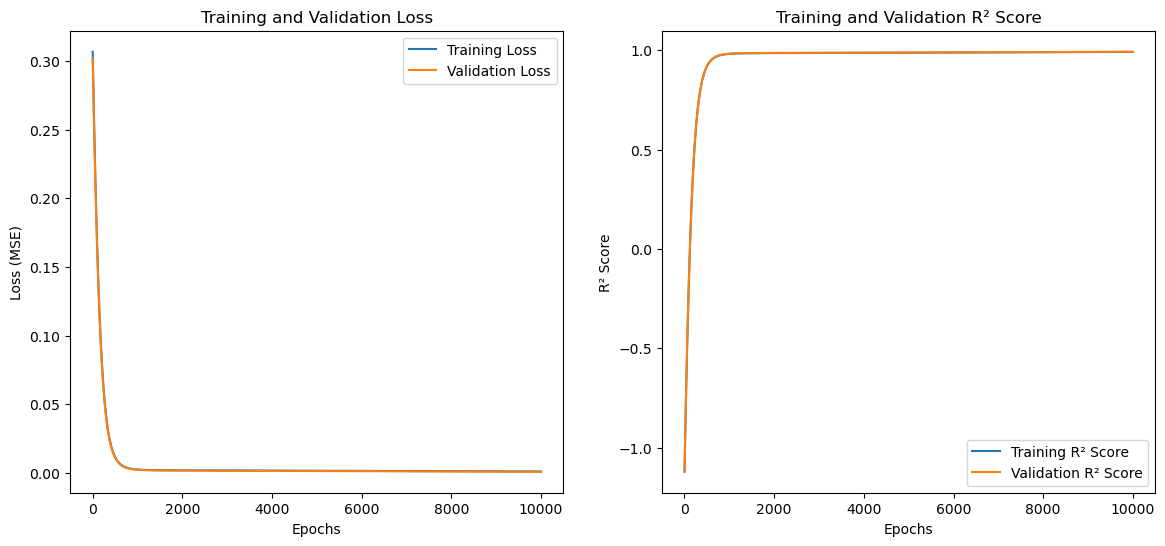

In [9]:
# Train the network and print the losses and R² scores
nn.train(X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs)

In [10]:
# Access the stored losses and accuracies
train_losses = nn.train_losses  # List of training losses
val_losses = nn.val_losses      # List of validation losses
train_r2_scores = nn.train_r2_scores  # List of training R² scores
val_r2_scores = nn.val_r2_scores      # List of validation R² scores

# Print the final losses and R² scores
print("Final Training Losses:", train_losses[-1])
print("Final Validation Losses:", val_losses[-1])
print("Final Training R² Scores:", train_r2_scores[-1])
print("Final Validation R² Scores:", val_r2_scores[-1])

Final Training Losses: 0.0011439449
Final Validation Losses: 0.0009818423
Final Training R² Scores: 0.9920885461271802
Final Validation R² Scores: 0.9931226731345894


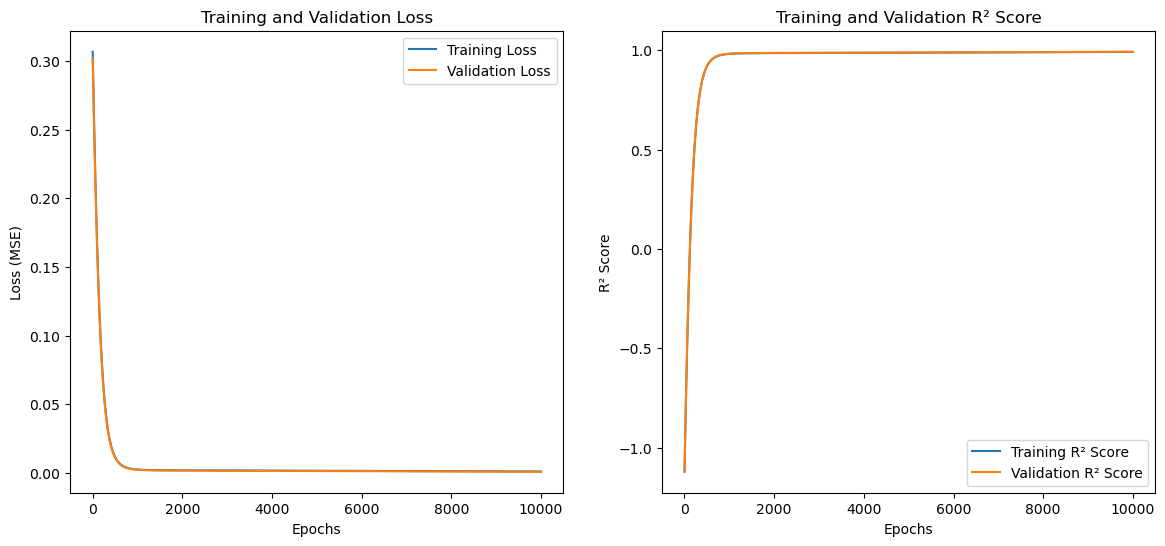

In [11]:
nn.plot_training_history(train_losses, val_losses, train_r2_scores, val_r2_scores)

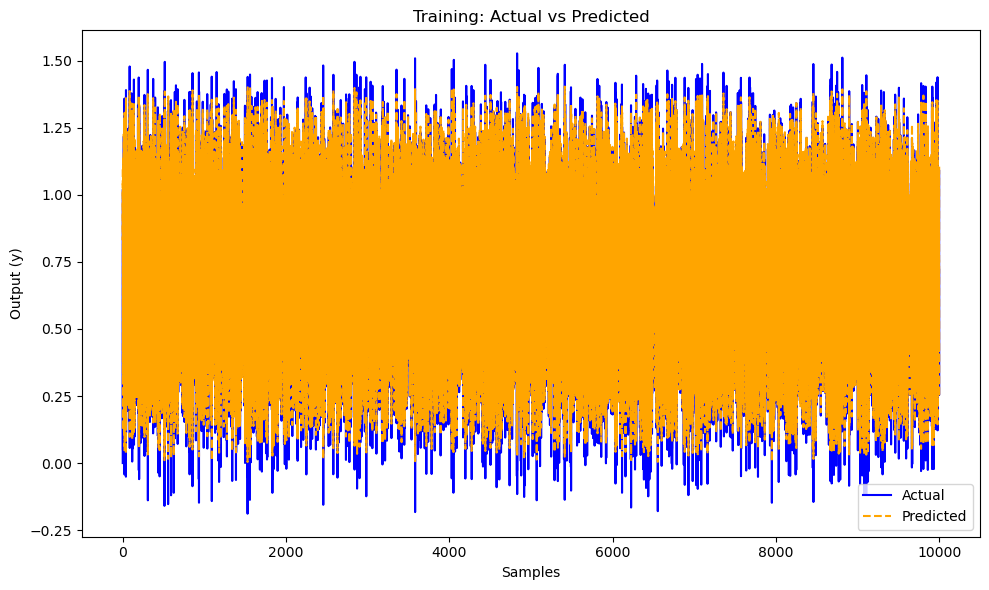

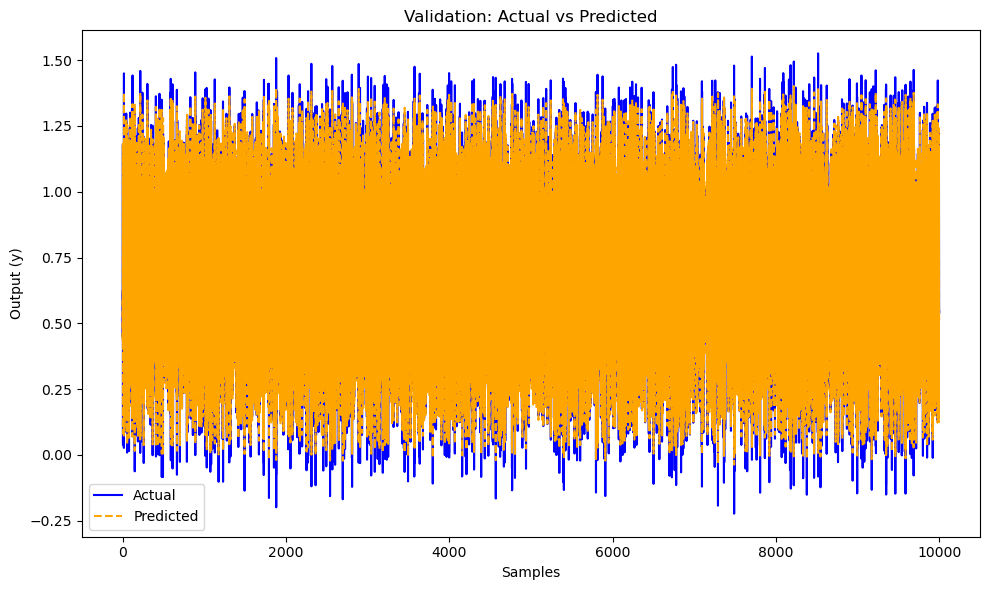

In [12]:
def plot_actual_vs_predicted(y_actual, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(10, 6))
    
    # Plot actual values
    plt.plot(y_actual, label="Actual", color="blue")
    
    # Plot predicted values
    plt.plot(y_pred, label="Predicted", color="orange", linestyle='dashed')
    
    # Labels and title
    plt.xlabel("Samples")
    plt.ylabel("Output (y)")
    plt.title(title)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Access the predictions for the training and validation sets
y_train_pred_norm = nn.y_train_pred  # Predicted values for the training set
y_val_pred_norm = nn.y_val_pred      # Predicted values for the validation set

# Denormalize the predictions
y_train_pred = denormalize(y_train_pred_norm, np.min(y_train), np.max(y_train))
y_val_pred = denormalize(y_val_pred_norm, np.min(y_val), np.max(y_val))

# Call the function to plot for training and validation
plot_actual_vs_predicted(y_train, y_train_pred, title="Training: Actual vs Predicted")
plot_actual_vs_predicted(y_val, y_val_pred, title="Validation: Actual vs Predicted")

In [13]:
# Access weights and biases after training
weights = nn.W  # List of weight matrices for each layer
biases = nn.b   # List of bias vectors for each layer

# Print weights and biases for each layer
for i, (W, b) in enumerate(zip(weights, biases)):
    print(f"Layer {i + 1} Weights (W{i+1}):")
    print(W)
    print(f"Layer {i + 1} Biases (b{i+1}):")
    print(b)
    print("=" * 50)

Layer 1 Weights (W1):
[[ 0.51262254  0.3391899   0.18525386  0.71695733 -0.62488526 -0.8975096
   0.605182  ]
 [-0.39015347 -0.68717915 -0.65917414  0.43370348  0.6525185   0.13660015
   0.20219688]
 [-0.4395358  -0.6424709  -0.17532957 -0.5054447  -0.3300081  -0.09676196
  -0.31410643]
 [ 0.25472143 -0.22514975 -0.28370482  0.23125505 -0.3843485  -0.78379357
   0.02165796]
 [-0.05517581  0.07002475 -0.21787281 -0.3524033  -0.16360214 -0.2666061
  -0.7195538 ]]
Layer 1 Biases (b1):
[[-0.01860467 -0.00409573  0.01902115 -0.00661636 -0.00144216 -0.00316889
   0.00245228]]
Layer 2 Weights (W2):
[[-0.54865724]
 [-0.08974925]
 [ 0.3035668 ]
 [-0.26621464]
 [ 0.09304395]
 [ 0.13840637]
 [-0.0179478 ]]
Layer 2 Biases (b2):
[[0.04128223]]


In [14]:
class NeuralNetworkStochastic:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, l2_lambda=0.001):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda  # L2 regularization parameter

        # Initialize weights and biases using Nguyen-Widrow initialization
        self.W = weights
        self.b = biases

        # Placeholder for initial y_pred values from previous training batches
        self.initial_y_train_pred = [y_train_pred_norm[0], y_train_pred_norm[1], y_train_pred_norm[2]]  # To store y_pred(0), y_pred(1), y_pred(2)
        self.initial_y_val_pred = [y_val_pred_norm[0], y_val_pred_norm[1], y_val_pred_norm[2]]  # To store y_pred(0), y_pred(1), y_pred(2)

    def nguyen_widrow_init(self, input_size, output_size):
        """Nguyen-Widrow initialization."""
        W = np.random.randn(input_size, output_size).astype(np.float32) * 0.5
        beta = 0.7 * (output_size ** (1.0 / input_size))
        norm = np.linalg.norm(W, axis=0)
        return beta * W / norm

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def mse_loss(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def r2_score(self, y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) + 1e-4  # Prevent division by zero
        return 1 - (ss_res / ss_tot)

    def forward(self, X):
        # Forward pass through all layers
        self.activations = []  # Store activations for backpropagation
        self.Z = []  # Store pre-activation values

        # Input to first hidden layer
        Z = np.dot(X, self.W[0]) + self.b[0]
        A = self.tanh(Z)
        self.Z.append(Z)
        self.activations.append(A)

        # Hidden layers
        for i in range(1, len(self.hidden_sizes)):
            Z = np.dot(self.activations[-1], self.W[i]) + self.b[i]
            A = self.tanh(Z)
            self.Z.append(Z)
            self.activations.append(A)

        # Output layer
        Z = np.dot(self.activations[-1], self.W[-1]) + self.b[-1]
        A = Z
        self.Z.append(Z)
        self.activations.append(A)

        return A
    
    def predict(self, X_new):
        """
        Predict the output for new input data.
        :param X_new: New input data (numpy array)
        :return: Predicted output (numpy array)
        """
        # Process the input through the network
        predictions = self.forward(X_new)
        return predictions

    def backward(self, X, y_true, y_pred, k):
        m = X.shape[0]  # Should be 1 for stochastic updates

        # Gradient for output layer
        dZ = (y_pred - y_true) # Derivative of MSE loss w.r.t. Z
        dW = np.dot(self.activations[-2].T, dZ) / m + (self.l2_lambda * self.W[-1] / m)  # Corrected shape alignment
        db = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases for output layer
        self.W[-1] -= self.learning_rate * dW
        self.b[-1] -= self.learning_rate * db

        # Backpropagate through the hidden layers
        for i in range(len(self.hidden_sizes) - 1, 0, -1):
            dA = np.dot(dZ, self.W[i + 1].T)
            dZ = dA * self.tanh_derivative(self.Z[i])
            dW = np.dot(self.activations[i - 1].T, dZ) / m + (self.l2_lambda * self.W[i] / m)
            db = np.sum(dZ, axis=0, keepdims=True) / m

            self.W[i] -= self.learning_rate * dW
            self.b[i] -= self.learning_rate * db

        # Gradient for the first hidden layer
        dA = np.dot(dZ, self.W[1].T)
        dZ = dA * self.tanh_derivative(self.Z[0])
        dW = np.dot(X.T, dZ) / m + (self.l2_lambda * self.W[0] / m)
        db = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases for the first hidden layer
        self.W[0] -= self.learning_rate * dW
        self.b[0] -= self.learning_rate * db

    def train(self, X_train, y_train, X_val, y_val, epochs):
        self.train_losses, self.val_losses = [], []
        self.train_r2_scores, self.val_r2_scores = [], []

        # Store predictions as lists to collect predictions for plotting
        self.train_predictions = []  # To store training predictions across iterations
        self.val_predictions = []    # To store validation predictions across iterations

        print(f"{'Epoch':<10}{'Train Loss':<15}{'Train R²':<15}{'Val Loss':<15}{'Val R²':<15}")
        print("=" * 70)

        for epoch in range(epochs):
            # Perform 1 epoch of training over all samples
            for i in range(X_train.shape[0]):
                # Use feedback mechanism for y(k-1) and y(k-2)
                if i == 0:
                    y_train_k_1 = self.initial_y_train_pred[0]
                    y_train_k_2 = self.initial_y_train_pred[1]
                    y_val_k_1 = self.initial_y_val_pred[0]
                    y_val_k_2 = self.initial_y_val_pred[1]
                else:
                    y_train_k_1 = y_train_pred_k_1
                    y_train_k_2 = y_train_pred_k_2
                    y_val_k_1 = y_val_pred_k_1
                    y_val_k_2 = y_val_pred_k_2

                # Prepare input samples
                X_train_sample = X_train[i].reshape(1, -1)
                X_train_sample[0, 0], X_train_sample[0, 1] = y_train_k_1, y_train_k_2
                X_val_sample = X_val[i].reshape(1, -1)
                X_val_sample[0, 0], X_val_sample[0, 1] = y_val_k_1, y_val_k_2

                # Forward pass
                y_train_pred = self.forward(X_train_sample)
                y_val_pred = self.forward(X_val_sample)

                # Update feedback variables for the next iteration
                if i == 0:
                    y_train_pred_k_2 = self.initial_y_train_pred[1]  # Shift values down
                    y_train_pred_k_1 = y_train_pred  # Store current prediction
                    y_val_pred_k_2 = self.initial_y_val_pred[1]
                    y_val_pred_k_1 = y_val_pred
                else:    
                    y_train_pred_k_2 = y_train_pred_k_1  # Shift values down
                    y_train_pred_k_1 = y_train_pred  # Store current prediction
                    y_val_pred_k_2 = y_val_pred_k_1
                    y_val_pred_k_1 = y_val_pred

                # Backward pass
                self.backward(X_train_sample, y_train[i].reshape(1, -1), y_train_pred, i)

            # After processing all samples, calculate loss and accuracy
            train_loss = self.mse_loss(y_train, self.predict(X_train))
            train_r2 = self.r2_score(y_train, self.predict(X_train))

            val_loss = self.mse_loss(y_val, self.predict(X_val))
            val_r2 = self.r2_score(y_val, self.predict(X_val))

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_r2_scores.append(train_r2)
            self.val_r2_scores.append(val_r2)

            # Print every 1000 epochs
            if (epoch + 1) % 10 == 0:
                print(f"{epoch + 1:<10}{train_loss:<15.4f}{train_r2:<15.4f}{val_loss:<15.4f}{val_r2:<15.4f}")

        print("=" * 70)
        print(f"Final Training Loss: {train_loss:.4f}, Final Training R²: {train_r2:.4f}")
        print(f"Final Validation Loss: {val_loss:.4f}, Final Validation R²: {val_r2:.4f}")

        # After training, plot the metrics
        self.plot_training_history(self.train_losses, self.val_losses, self.train_r2_scores, self.val_r2_scores)

    def plot_training_history(self, train_losses, val_losses, train_r2_scores, val_r2_scores):
        epochs_range = range(1, len(train_losses) + 1)

        plt.figure(figsize=(14, 6))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_losses, label="Training Loss")
        plt.plot(epochs_range, val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (MSE)")
        plt.title("Training and Validation Loss")
        plt.legend()

        # R² Scores plot (Accuracy)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_r2_scores, label="Training R² Score")
        plt.plot(epochs_range, val_r2_scores, label="Validation R² Score")
        plt.xlabel("Epochs")
        plt.ylabel("R² Score")
        plt.title("Training and Validation R² Score")
        plt.legend()

        plt.show()


In [15]:
# Initialize the neural network
input_size = 5
hidden_sizes = [7]  # Five hidden layers with 7 neurons each
output_size = 1
learning_rate = 0.01  # Reduced learning rate for stability
l2_lambda = 0.001  # Regularization parameter
epochs = 500

nns = NeuralNetworkStochastic(input_size, hidden_sizes, output_size, learning_rate, l2_lambda)

In [ ]:
nns.train(X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs)

In [ ]:
# Access the stored losses and accuracies
train_losses = nns.train_losses  # List of training losses
val_losses = nns.val_losses      # List of validation losses
train_r2_scores = nns.train_r2_scores  # List of training R² scores
val_r2_scores = nns.val_r2_scores      # List of validation R² scores

# Print the final losses and R² scores
print("Final Training Losses:", train_losses[-1])
print("Final Validation Losses:", val_losses[-1])
print("Final Training R² Scores:", train_r2_scores[-1])
print("Final Validation R² Scores:", val_r2_scores[-1])

In [ ]:
y_train_pred_norm = nns.predict(X_train_norm)
y_val_pred_norm = nns.predict(X_val_norm)

# Denormalize the predictions
y_train_pred = denormalize(y_train_pred_norm, np.min(y_train), np.max(y_train))
y_val_pred = denormalize(y_val_pred_norm, np.min(y_val), np.max(y_val))

# Call the function to plot for training and validation
plot_actual_vs_predicted(y_train, y_train_pred, title="Training: Actual vs Predicted")
plot_actual_vs_predicted(y_val, y_val_pred, title="Validation: Actual vs Predicted")

In [20]:
# Define the number of samples
k_max = 20000
t_test = np.linspace(0, k_max, k_max)  # Time variable

# Generate sinusoidal input for u_test(k)
frequency = 10  # Adjust the frequency as needed
amplitude = 10    # Amplitude of the sine wave
phase = 0         # Phase shift of the sine wave
u_test = amplitude * np.sin(2 * np.pi * frequency * t_test + phase).astype(np.float32)

# Initialize y_test(k) array with dtype float32
y_test = np.zeros(k_max, dtype=np.float32)

# Define y_test(k) calculations with dtype float32
for k in range(1, k_max):
    y_test[k] = np.float32(1 / (1 + (y_test[k-1])**2)) + np.float32(0.25 * u_test[k]) - np.float32(0.3 * u_test[k-1])

# Shift arrays for y_test(k-1), y_test(k-2), u_test(k-1), u_test(k-2)
y_k_1_test = np.zeros(k_max, dtype=np.float32)
y_k_2_test = np.zeros(k_max, dtype=np.float32)
u_k_1_test = np.zeros(k_max, dtype=np.float32)
u_k_2_test = np.zeros(k_max, dtype=np.float32)

# Shifted arrays for testing
y_k_1_test[1:] = y_test[:-1]
y_k_2_test[2:] = y_test[:-2]
u_k_1_test[1:] = u_test[:-1]
u_k_2_test[2:] = u_test[:-2]

# Normalize inputs and outputs separately
u_test_norm = normalize(u_test)            # Normalize input u(k)
u_k_1_test_norm = normalize(u_k_1_test)    # Normalize u(k-1)
u_k_2_test_norm = normalize(u_k_2_test)    # Normalize u(k-2)
y_test_norm = normalize(y_test)            # Normalize output y(k) 
y_k_1_test_norm = normalize(y_k_1_test)    # Normalize y(k-1) 
y_k_2_test_norm = normalize(y_k_2_test)   # Normalize y(k-2)

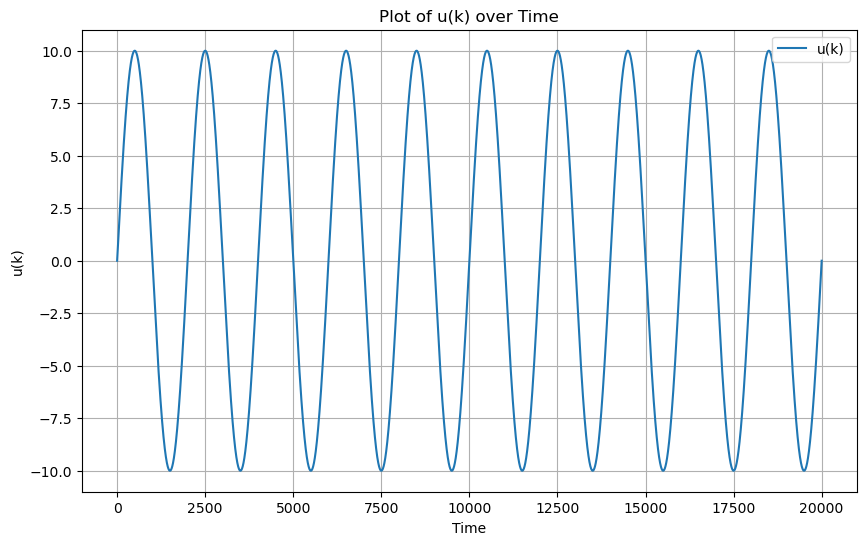

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, u_test, label='u(k)')
plt.xlabel('Time')
plt.ylabel('u(k)')
plt.title('Plot of u(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

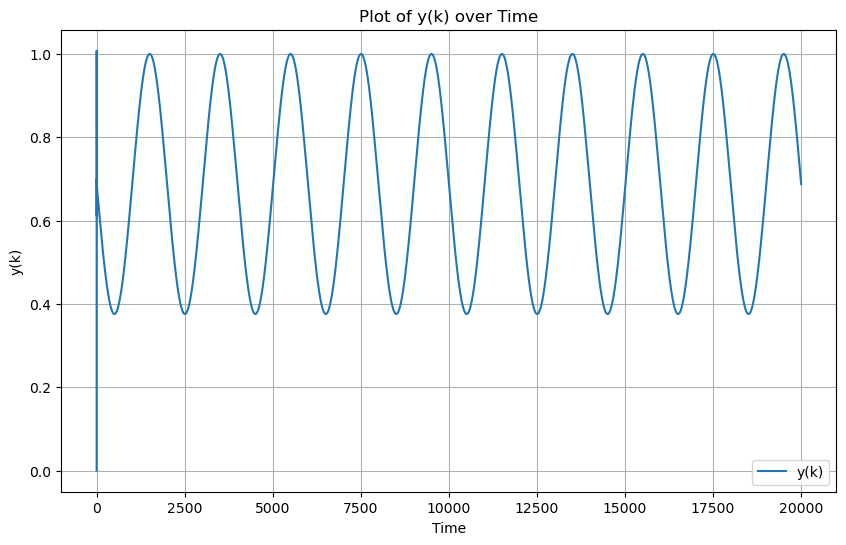

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, y_test, label='y(k)')
plt.xlabel('Time')
plt.ylabel('y(k)')
plt.title('Plot of y(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
X_test_norm = np.array([y_k_1_test_norm, y_k_2_test_norm, u_test_norm, u_k_1_test_norm, u_k_2_test_norm]).T
y_test_pred_nn_norm = nn.predict(X_test_norm)
# y_test_pred_nns_norm = nns.predict(X_test_norm)

# Denormalize the predictions
y_test_pred_nn = denormalize(y_test_pred_nn_norm, np.min(y_test), np.max(y_test))
# y_test_pred_nns = denormalize(y_test_pred_nns_norm, np.min(y_test), np.max(y_test))

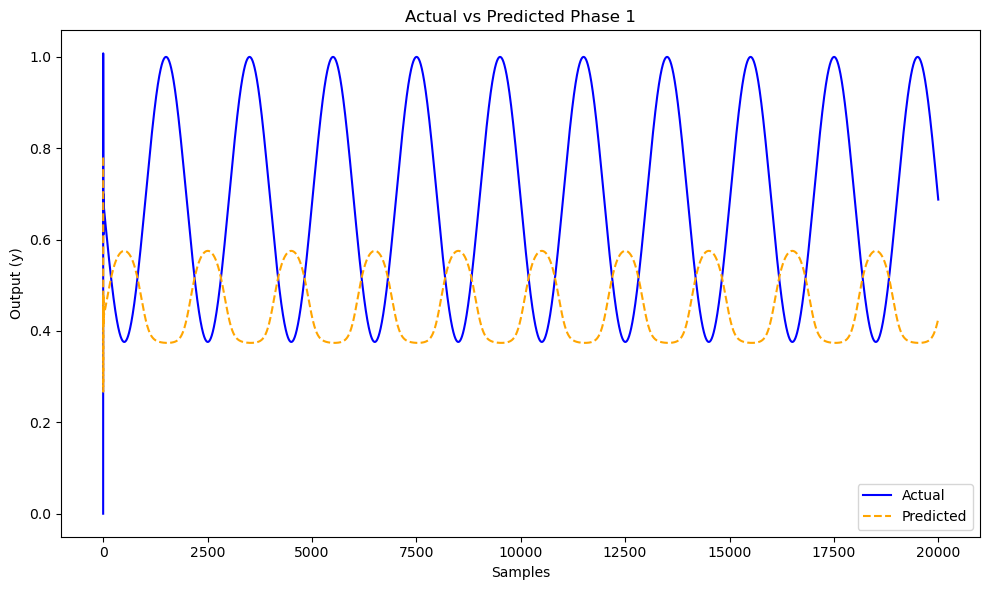

In [24]:
plot_actual_vs_predicted(y_test, y_test_pred_nn, title="Actual vs Predicted Phase 1")

In [ ]:
plot_actual_vs_predicted(y_test, y_test_pred_nns, title="Actual vs Predicted Phase 2")

In [30]:
# Define the number of samples
k_max = 20000
t_test = np.linspace(0, k_max, k_max)  # Time variable

# Generate square wave input for u_test(k)
frequency = 5  # Adjust the frequency as needed
amplitude = 1    # Amplitude of the square wave
duty_cycle = 0.5  # Duty cycle of the square wave (0.5 for a 50% duty cycle)
u_test_square = (amplitude * np.sign(np.sin(2 * np.pi * frequency * t_test)) * 0.5 + 0.5).astype(np.float32)

# Initialize y_test(k) array with dtype float32
y_test_square = np.zeros(k_max, dtype=np.float32)

# Define y_test(k) calculations with dtype float32
for k in range(1, k_max):
    y_test_square[k] = np.float32(1 / (1 + (y_test_square[k-1])**2)) + np.float32(0.25 * u_test_square[k]) - np.float32(0.3 * u_test_square[k-1])

# Shift arrays for y_test(k-1), y_test(k-2), u_test(k-1), u_test(k-2)
y_k_1_square = np.zeros(k_max, dtype=np.float32)
y_k_2_square = np.zeros(k_max, dtype=np.float32)
u_k_1_square = np.zeros(k_max, dtype=np.float32)
u_k_2_square = np.zeros(k_max, dtype=np.float32)

# Shifted arrays for testing
y_k_1_square[1:] = y_test_square[:-1]
y_k_2_square[2:] = y_test_square[:-2]
u_k_1_square[1:] = u_test_square[:-1]
u_k_2_square[2:] = u_test_square[:-2]

# Normalize inputs and outputs separately
u_test_square_norm = normalize(u_test_square)            # Normalize input u(k)
u_k_1_square_norm = normalize(u_k_1_square)    # Normalize u(k-1)
u_k_2_square_norm = normalize(u_k_2_square)    # Normalize u(k-2)
y_test_square_norm = normalize(y_test_square)            # Normalize output y(k)
y_k_1_square_norm = normalize(y_k_1_square)    # Normalize y(k-1)
y_k_2_square_norm = normalize(y_k_2_square)   # Normalize y(k-2)


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, u_test_square, label='u(k)')
plt.xlabel('Time')
plt.ylabel('u(k)')
plt.title('Plot of u(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, y_test_square, label='y(k)')
plt.xlabel('Time')
plt.ylabel('y(k)')
plt.title('Plot of y(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
X_test_square_norm = np.array([y_k_1_square_norm, y_k_2_square_norm, u_test_square_norm, u_k_1_square_norm, u_k_2_square_norm]).T
y_test_pred_nn_square = nn.predict(X_test_square_norm)
y_test_pred_nns_square = nns.predict(X_test_square_norm)

# Denormalize the predictions
y_test_pred_nn_square = denormalize(y_test_pred_nn_square, np.min(y_test_square), np.max(y_test_square))
y_test_pred_nns_square = denormalize(y_test_pred_nns_square, np.min(y_test_square), np.max(y_test_square))

In [ ]:
plot_actual_vs_predicted(y_test_square, y_test_pred_nn_square, title="Actual vs Predicted Phase 1")

In [ ]:
plot_actual_vs_predicted(y_test_square, y_test_pred_nns_square, title="Actual vs Predicted Phase 2")

In [ ]:
# Define step input for u_test(k)
amplitude = 10  # Amplitude of the step input
u_test_step = amplitude * np.ones(k_max, dtype=np.float32)

# Initialize y_test(k) array with dtype float32
y_test_step = np.zeros(k_max, dtype=np.float32)

# Define y_test(k) calculations with dtype float32
for k in range(1, k_max):
    y_test_step[k] = np.float32(1 / (1 + (y_test_step[k-1])**2)) + np.float32(0.25 * u_test_step[k]) - np.float32(0.3 * u_test_step[k-1])

# Shift arrays for y_test(k-1), y_test(k-2), u_test(k-1), u_test(k-2)
y_k_1_step = np.zeros(k_max, dtype=np.float32)
y_k_2_step = np.zeros(k_max, dtype=np.float32)
u_k_1_step = np.zeros(k_max, dtype=np.float32)
u_k_2_step = np.zeros(k_max, dtype=np.float32)

# Shifted arrays for testing
y_k_1_step[1:] = y_test_step[:-1]
y_k_2_step[2:] = y_test_step[:-2]
u_k_1_step[1:] = u_test_step[:-1]
u_k_2_step[2:] = u_test_step[:-2]

# Normalize inputs and outputs separately
u_test_step_norm = normalize(u_test_step)            # Normalize input u(k)
u_k_1_step_norm = normalize(u_k_1_step)    # Normalize u(k-1)
u_k_2_step_norm = normalize(u_k_2_step)    # Normalize u(k-2)
y_test_step_norm = normalize(y_test_step)            # Normalize output y(k)
y_k_1_step_norm = normalize(y_k_1_step)    # Normalize y(k-1)
y_k_2_step_norm = normalize(y_k_2_step)   # Normalize y(k-2)


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, u_test_step, label='u(k)')
plt.xlabel('Time')
plt.ylabel('u(k)')
plt.title('Plot of u(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, y_test_step, label='y(k)')
plt.xlabel('Time')
plt.ylabel('y(k)')
plt.title('Plot of y(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Prepare test input for the neural network
X_test_step_norm = np.array([y_k_1_step_norm, y_k_2_step_norm, u_test_step_norm, u_k_1_step_norm, u_k_2_step_norm]).T
y_test_pred_nn_step_norm = nn.predict(X_test_step_norm)
y_test_pred_nns_step_norm = nns.predict(X_test_step_norm)

# Denormalize the predictions
y_test_pred_nn_step = denormalize(y_test_pred_nn_step_norm, np.min(y_test_step), np.max(y_test_step))
y_test_pred_nns_step = denormalize(y_test_pred_nns_step_norm, np.min(y_test_step), np.max(y_test_step))


In [ ]:
plot_actual_vs_predicted(y_test_step, y_test_pred_nn_step, title="Actual vs Predicted Phase 1")

In [ ]:
plot_actual_vs_predicted(y_test_step, y_test_pred_nns_step, title="Actual vs Predicted Phase 2")

In [42]:
# Generate ramp input for u_test(k)
start_value = 0
end_value = 10
u_test_ramp = np.linspace(start_value, end_value, k_max, dtype=np.float32)

# Initialize y_test(k) array with dtype float32
y_test_ramp = np.zeros(k_max, dtype=np.float32)

# Define y_test(k) calculations with dtype float32
for k in range(1, k_max):
    y_test_ramp[k] = np.float32(1 / (1 + (y_test_ramp[k-1])**2)) + np.float32(0.25 * u_test_ramp[k]) - np.float32(0.3 * u_test_ramp[k-1])

# Shift arrays for y_test(k-1), y_test(k-2), u_test(k-1), u_test(k-2)
y_k_1_ramp = np.zeros(k_max, dtype=np.float32)
y_k_2_ramp = np.zeros(k_max, dtype=np.float32)
u_k_1_ramp = np.zeros(k_max, dtype=np.float32)
u_k_2_ramp = np.zeros(k_max, dtype=np.float32)

# Shifted arrays for testing
y_k_1_ramp[1:] = y_test_ramp[:-1]
y_k_2_ramp[2:] = y_test_ramp[:-2]
u_k_1_ramp[1:] = u_test_ramp[:-1]
u_k_2_ramp[2:] = u_test_ramp[:-2]

# Normalize inputs and outputs separately
u_test_ramp_norm = normalize(u_test_ramp)            # Normalize input u(k)
u_k_1_ramp_norm = normalize(u_k_1_ramp)    # Normalize u(k-1)
u_k_2_ramp_norm = normalize(u_k_2_ramp)    # Normalize u(k-2)
y_test_ramp_norm = normalize(y_test_ramp)            # Normalize output y(k)
y_k_1_ramp_norm = normalize(y_k_1_ramp)    # Normalize y(k-1)
y_k_2_ramp_norm = normalize(y_k_2_ramp)   # Normalize y(k-2)


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, u_test_ramp, label='u(k)')
plt.xlabel('Time')
plt.ylabel('u(k)')
plt.title('Plot of u(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, y_test_ramp, label='y(k)')
plt.xlabel('Time')
plt.ylabel('y(k)')
plt.title('Plot of y(k) over Time')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Prepare test input for the neural network
X_test_ramp_norm = np.array([y_k_1_ramp_norm, y_k_2_ramp_norm, u_test_ramp_norm, u_k_1_ramp_norm, u_k_2_ramp_norm]).T
y_test_pred_nn_ramp = nn.predict(X_test_ramp_norm)
y_test_pred_nns_ramp = nns.predict(X_test_ramp_norm)

# Denormalize the predictions
y_test_pred_nn_ramp = denormalize(y_test_pred_nn_ramp, np.min(y_test_ramp), np.max(y_test_ramp))
y_test_pred_nns_ramp = denormalize(y_test_pred_nns_ramp, np.min(y_test_ramp), np.max(y_test_ramp))


In [ ]:
plot_actual_vs_predicted(y_test_ramp, y_test_pred_nn_ramp, title="Actual vs Predicted Phase 1")

In [ ]:
plot_actual_vs_predicted(y_test_ramp, y_test_pred_nns_ramp, title="Actual vs Predicted Phase 2")